##Context Encoder


### Import modules

In [1]:
# Import all needed modules
import os
import zipfile 
import gdown
import torch
import time
import torchvision.transforms as T
import random as rnd
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from natsort import natsorted
from PIL import Image
from matplotlib import pyplot as plt
from torchvision.transforms import functional as TF
from torchvision.utils import make_grid,save_image
from torchvision.datasets import ImageFolder,DatasetFolder
from torch.utils.data import Dataset,DataLoader,Subset
from torch.autograd import Variable
from torchvision.transforms import InterpolationMode
from numpy.random import choice
from numpy.random import seed as np_seed

###Download and prepare the dataset folder

In [2]:
# Path to root folder
data_root = 'data/celeba'
# Path to folder with the dataset
dataset_folder = f'{data_root}/img_align_celeba'
# URL for the CelebA dataset
url = 'https://drive.google.com/uc?id=1cNIac61PSA_LqDFYFUeyaQYekYPc75NH'
# Path to download the dataset to
download_path = f'{data_root}/img_align_celeba.zip'

# Create required directories 
if not os.path.exists(data_root):
  os.makedirs(data_root)
  os.makedirs(dataset_folder)

# Download the dataset from google drive
if not os.path.isfile(download_path):
  gdown.download(url, download_path, quiet=True)  
  # Unzip the downloaded file 
  with zipfile.ZipFile(download_path, 'r') as ziphandler:
    ziphandler.extractall(dataset_folder)
    
## Load the dataset 
# Path to directory with all the images
img_folder = f'{dataset_folder}/img_align_celeba'

In [3]:
## Create a custom Dataset class
class CelebADataset(Dataset):
  def __init__(self, root_dir, transform=None):
    """
    Args:
      root_dir (string): Directory with all the images
      transform (callable, optional): transform to be applied to each image sample
    """
    # Read names of images in the root directory
    image_names = os.listdir(root_dir)
    self.root_dir = root_dir
    self.transform = transform 
    self.image_names = natsorted(image_names)

  def __len__(self): 
    return len(self.image_names)

  def __getitem__(self, idx):
    # Get the path to the image 
    img_path = os.path.join(self.root_dir, self.image_names[idx])
    # Load image and convert it to RGB
    img = Image.open(img_path).convert('RGB')
    # Apply transformations to the image
    if self.transform:
        img = self.transform(img)
    return img

#### Define Variables 

In [4]:
# cudnn will look for the optimal set of algorithms for that particular configuration False for Reproducibility | True for better performance
cudnn.benchmark = False 
# Enable cuda if available
if torch.cuda.is_available():
  Tensor = torch.cuda.FloatTensor
  dev = 'cuda'
else :
  Tensor = torch.FloatTensor
  dev = 'cpu'
#set random seed
seed_value = torch.randint(0,1000,(1,),device=dev).item()
##else manual seed
#seed_value = 0 
print(f"seed value: {seed_value}")
rnd.seed(seed_value)
torch.manual_seed(seed_value)
np_seed(seed_value)
# Enable deterministic_algorithms for replayability 
torch.use_deterministic_algorithms(True)

norm_mean = (0.5, 0.5, 0.5)
norm_std = (0.5, 0.5, 0.5)
# Number of channel RGB 3
channel = 3 
# Imgage size will be Cx128x128
img_size = 128
# Mask size it's the size of center mask Cx64x64
mask_size = 64
# Number of pixels overlapped
overlapPred = 4  
# Size of batches
batch_size = 64
#  the lower is res value, the more continuous the output will be.
## Value to generate a random patter of 1 and 0 to create a random region
res = 0.06
density = 0.25
MAX_SIZE = 10000
# Paths 
save_path_discriminator = "/content/checkpoint_discriminator.pth"
save_path_generator = "/content/checkpoint_generator.pth"
# Restore backups
restore = False
#Transform definition
resize = T.Resize(img_size,InterpolationMode.BICUBIC) 
center_crop = T.CenterCrop(img_size)
to_tensor = T.ToTensor()
normalize = T.Normalize(norm_mean, norm_std)
# Compose
transform = T.Compose([resize,center_crop,to_tensor, normalize
])

seed value: 596


In [5]:
# Load the dataset from file and apply transformations
celeba_dataset = CelebADataset(img_folder, transform)
# Split training and testset
num_train = len(celeba_dataset)
train_idx = list(range(num_train))
rnd.shuffle(train_idx)
test_frac = 0.3
num_test = int(num_train*test_frac)
num_train = num_train - num_test
test_idx = train_idx[num_train:]
train_idx = train_idx[:num_train]
test_dataset = Subset(celeba_dataset, test_idx)
train_dataset = Subset(celeba_dataset, train_idx)

train_loader = DataLoader(train_dataset,batch_size=batch_size,num_workers=2,shuffle=True,drop_last=True,pin_memory = True)
test_loader= DataLoader(test_dataset,batch_size=batch_size,num_workers=2,shuffle=True,drop_last=True,pin_memory = True)

### Function definition 

#### Mask Function


In [6]:
def generate_pattern():   
    low_pattern = Variable(Tensor(int(res*MAX_SIZE),int(res*MAX_SIZE)), requires_grad=False)
    low_pattern = low_pattern.uniform_(0,1).mul(255)
    pattern = TF.resize(TF.to_pil_image(low_pattern),(MAX_SIZE,MAX_SIZE))
    low_patter= None
    pattern = to_tensor(pattern).to(dev)
    #lt gives a boolean matrix of 75% 0 and 25% true based on density 
    pattern = torch.lt(pattern,density).squeeze(0)
    return pattern

def apply_random_masks(images,pattern):
    wastedIter = 0
    while True:
        x =  torch.randint(1,MAX_SIZE-img_size,(1,),device=dev).item()
        y =  torch.randint(1,MAX_SIZE-img_size,(1,),device=dev).item()
        # Select from the patter a random region of true/false
        mask = pattern[y:y+img_size,x:x+img_size] 
        area = (mask.sum().item())*100/(img_size*img_size)
        #the area should be 1/4 of the image
        if area>20 and area<30:
            #print('wasted tries: ',wastedIter)
            break
        wastedIter = wastedIter + 1
    mask.unsqueeze_(0).cuda()
    mask = mask.repeat(batch_size,channel, 1, 1)
    vector  = [2*117.0/255.0 - 1.0,2*104.0/255.0 - 1.0,2*123.0/255.0 - 1.0] #mean values for each colours 
    #trunk to float 
    for n in vector:
        float(n)
    ### fix a bug with pytorch    
    mask = mask.float().cpu()
    for i in range(3):
      color_d = mask[:,i,:,:]
      color_d[color_d==1] = vector[i]

    index_to_substitute = mask!=0  
    images = images.cpu()
    images[index_to_substitute] = 0
    # sum images with the mask made up of 0 and 1    
    sum_img = images +mask
    sum_img.cuda()

    return sum_img

def apply_random_blocks(images):
        #create 8 mini blocks on the image
        size_mini_block = 22
        for x in range(8):
            y1 = torch.randint(1,img_size-overlapPred-size_mini_block,(1,),device=dev).item()
            x1 = torch.randint(1,img_size-overlapPred-size_mini_block,(1,),device=dev).item()
            y2, x2 = y1 + size_mini_block, x1 + size_mini_block
            #mean values for each colours 
            images[:,0, y1+overlapPred:y2-overlapPred, x1+overlapPred:x2-overlapPred] = 2*117.0/255.0 - 1.0
            images[:,1, y1+overlapPred:y2-overlapPred, x1+overlapPred:x2-overlapPred] = 2*104.0/255.0 - 1.0
            images[:,2, y1+overlapPred:y2-overlapPred, x1+overlapPred:x2-overlapPred] = 2*123.0/255.0 - 1.0
        return images

def apply_center_mask(images):
    img = images.clone()
    #remove center of the images with mean values for each colours 
    img[:,0,(mask_size//2)+overlapPred:img_size-(mask_size//2)-overlapPred,(mask_size//2)+overlapPred:img_size-(mask_size//2)-overlapPred]  = 2*117.0/255.0 - 1.0
    img[:,1,(mask_size//2)+overlapPred:img_size-(mask_size//2)-overlapPred,(mask_size//2)+overlapPred:img_size-(mask_size//2)-overlapPred]  = 2*104.0/255.0 - 1.0
    img[:,2,(mask_size//2)+overlapPred:img_size-(mask_size//2)-overlapPred,(mask_size//2)+overlapPred:img_size-(mask_size//2)-overlapPred]  = 2*123.0/255.0 - 1.0
    return img

def get_center(images):
    # get the center of the images
    center = images.clone()
    center = center[:,:,(mask_size//2):img_size-(mask_size//2),(mask_size//2):img_size-(mask_size//2)]  
    return center

def choise_mask(images,pattern,T=-4):
    '''  
     images: images to process
     patter: the matrix to extrapolate random region useful only for apply_random_masks
     T: default generate a random uniform value that choice one of the masks to apply
     lternative you can choice one specific 
    '''
    apply_mask = images.clone()   
    if T < -1 :
        value = torch.randint(0,3,(1,),device=dev).item()
    else :
      value = T
    if value == 0:
        return apply_random_blocks(apply_mask)
    if value == 1:
       return  apply_center_mask(apply_mask)
    if value == 2:
        return apply_random_masks(apply_mask,pattern)        

#### Labels noise function


In [7]:
def noisy_labels(y, p_flip) :
  # determine the number of labels to flip
  n_select = int(p_flip * y.shape[0])
  # choose labels to flip
  flip_ix = choice([i for i in range(y.shape[0])], size=n_select)
  # invert the labels in place
  y[flip_ix] = 1 - y[flip_ix]
  return y

def label_smoothing_valid(label) :
  label = label - 0.1 + (torch.rand(valid.shape,device=dev)*0.1)
  for i in range(batch_size):
    # for flipped 0 values that are negative 
    if label[i]<0.9:
    # multiply -1 to turn positive
        label[i] *=-1 
  return label
def label_smoothing_fake(label) :
  label = label + (torch.rand(valid.shape,device=dev)*0.1)
  for i in range(batch_size):
    # for flipped 1 values that are greater then 1 
    if label[i]>1.0:
        label[i] +=-0.1 
  return label    


#### Training function


In [8]:
def weights_init_normal(m):
    # Initialize model
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)
        
def Models():
    #Create model 
    latent_dim = 4000
    g_net=Generator(latent_dim)
    d_net=Discriminator()
    g_optimizer = optim.Adam(g_net.parameters(), lr=0.0002, betas=(0.5,0.999), weight_decay=5e-4)
    d_optimizer = optim.Adam(d_net.parameters(), lr=0.0002, betas=(0.5,0.999), weight_decay=5e-4)
    # Move models
    g_net = g_net.to(dev)
    d_net = d_net.to(dev)
    return g_net,d_net,g_optimizer,d_optimizer

def compare_and_save(photo_to_save,path,test_loader,g_net):
    test_image= next(iter(test_loader))
    test_image = test_image.to(dev)
    test_masked_imgs =test_image.clone() 
    if not os.path.exists(path):
        os.makedirs(path)
    with torch.no_grad():
                # Removing center from the test sample
                sample = apply_center_mask(test_image)
                # Forward (generator)
                g_sample = g_net(sample)
                # Impanting the image generated to the original
                test_masked_imgs[:,:,(mask_size//2):img_size-(mask_size//2),(mask_size//2):img_size-(mask_size//2)] = g_sample.data
                for i in range(photo_to_save):
                    generated =  (test_image[i,:,:,:]).unsqueeze(0)
                    original =  (test_masked_imgs[i,:,:,:]).unsqueeze(0)
                    compare = torch.cat((original, generated), 0).clone()
                    save_image(compare, path+"%d.png" % i, nrow=2, normalize=True)   

def training(train_loader,test_loader,labels_noise=False,wtl2= 0.999,last_epoch=200,save_photos_interval=10,overlapL2Weight=10):
    '''
    train_loader: Dataloader of train data
    test_loader : Dataloader of test data
    labels_noise: Boolean that enable labels smoothing and flipping
    wtl2: param to weights losses 
    last_epoch: number of last epoch
    save_photos_interval: set interval of every x epoch generate photos to compare
    overlapL2Weight: weights amplified 

    '''
    # Define labels 
    valid = Variable(Tensor(batch_size).fill_(1.0), requires_grad=False)
    fake = Variable(Tensor(batch_size).fill_(0.0), requires_grad=False)
    path_toSave_photos = "/content/images/"
    total_time = 0
    pattern = generate_pattern()
    # load test image
    test_image= next(iter(test_loader))
    test_image = test_image.to(dev)
    test_masked_imgs =test_image.clone() 
    # Create the models 
    g_net,d_net,g_optimizer,d_optimizer = Models()
    # If backup it's available load it 
    if os.path.isfile(save_path_discriminator) and os.path.isfile(save_path_generator) and restore:
        checkpoint_d =  torch.load(save_path_discriminator)
        checkpoint_g =  torch.load(save_path_generator)
        d_net.load_state_dict(checkpoint_d['d_state_dict'])
        d_optimizer.load_state_dict(checkpoint_d['optimizer_state_dict'])
        d_loss = checkpoint_d['loss']
        d_loss_fake = checkpoint_d['loss_fake']
        d_loss_real = checkpoint_d['loss_real']
        g_net.load_state_dict(checkpoint_g['g_state_dict'])
        g_optimizer.load_state_dict(checkpoint_g['optimizer_state_dict'])
        g_loss = checkpoint_g['loss']    
        g_loss_pixel = checkpoint_g['loss_pixel']
        g_loss_adv = checkpoint_g['loss_adv']
        epoch_backup = checkpoint_g['epoch']+1
        print("Discriminator and Generator restored")
    else :
        epoch_backup = 0 
        g_net.apply(weights_init_normal)
        d_net.apply(weights_init_normal)
        print("weight applied")
    try:
        for epoch in range(epoch_backup,last_epoch):
            # Losses
            start = time.time()
            sum_d_loss = 0
            sum_d_fake_loss = 0
            sum_d_real_loss = 0
            sum_g_loss = 0
            sum_g_loss_adv = 0
            sum_g_loss_pixel = 0
            # Training mode
            d_net.train()
            g_net.train()
            # Process all training batches
            i = 0
    
            for batch in train_loader:
                batch = batch.to(dev)
                # Move to device
                i+=1
                masked_parts = get_center(batch)
                #masked_parts are the center of the images 
                masked_parts = Variable(masked_parts.type(Tensor))
                masked_imgs = choise_mask(batch,pattern)
                masked_imgs = Variable(masked_imgs.type(Tensor))

                if labels_noise:
                    # probability of flipping 0.05
                    valid_flipped = noisy_labels(valid.clone(), 0.05)
                    fake_flipped = noisy_labels(fake.clone(), 0.05)  
                    valid_smooth = label_smoothing_valid(valid_flipped)
                    fake_smooth = label_smoothing_fake(fake_flipped)   

                ### Discriminator 
                # Reset discriminator gradient
                d_optimizer.zero_grad()
                # Forward (discriminator, real)
                output = d_net(masked_parts) 
                # Compute loss (discriminator, real)
                if labels_noise:
                  d_real_loss =  F.binary_cross_entropy(output, valid_smooth)
                else:
                  d_real_loss =  F.binary_cross_entropy(output, valid)
                # Backward (discriminator, real)
                d_real_loss.backward()
                sum_d_real_loss += d_real_loss.item()  
                #generate sample from masked images         
                g_output = g_net(masked_imgs)
                # Forward (discriminator, fake; also generator forward pass)
                output = d_net(g_output.detach()) # This prevents backpropagation from going inside the generator
                # Compute loss (discriminator, fake)
                if labels_noise:
                  d_fake_loss = F.binary_cross_entropy(output, fake_smooth)
                else:  
                  d_fake_loss = F.binary_cross_entropy(output, fake)
                # Backward (discriminator, fake)
                d_fake_loss.backward()
                sum_d_fake_loss += d_fake_loss.item()           
                d_loss = 0.5*(d_fake_loss + d_real_loss)
                sum_d_loss += d_loss.item()
                # Update discriminator
                d_optimizer.step()
                ### Generator 
                g_optimizer.zero_grad()
                # Forward (generator)
                output =  d_net(g_output)
                # Compute adversarial loss
                g_loss_adv = F.binary_cross_entropy(output, valid)            
                # Comput pixelwise loss
                # but amplifying weights 10x 
                #g_loss_pixel =  criterionMSE(g_output,masked_parts)
                wtl2Matrix = masked_parts.clone()
                # OverlapL2weight = 10
                wtl2Matrix.data.fill_(wtl2*overlapL2Weight)
                wtl2Matrix.data[:,:,overlapPred:mask_size-overlapPred,overlapPred:mask_size-overlapPred] = wtl2
                # MSE Loss
                g_loss_pixel = (g_output-masked_parts).pow(2)
                # Multiply 
                g_loss_pixel = g_loss_pixel * wtl2Matrix
                g_loss_pixel = g_loss_pixel.mean()
                # The losse it's the sum of adv and pixel
                g_loss = (1-wtl2) * g_loss_adv + wtl2 * g_loss_pixel
                sum_g_loss_adv += g_loss_adv.item()
                sum_g_loss_pixel += g_loss_pixel.item()
                sum_g_loss += g_loss.item()
                # Backward (generator)
                g_loss.backward()
                # Update generator
                g_optimizer.step()
                if (i%700==0):
                    print(f"Batches {i}/{len(train_loader)}")

            # Epoch end, print losses
            epoch_d_loss = sum_d_loss/len(train_loader)
            epoch_d_real_loss = sum_d_real_loss/len(train_loader)
            epoch_d_fake_loss = sum_d_fake_loss/len(train_loader)
            epoch_g_loss_adv = sum_g_loss_adv/len(train_loader)
            epoch_g_loss_pixel = sum_g_loss_pixel/len(train_loader)
            epoch_g_loss = sum_g_loss/len(train_loader)
            end = time.time()   
            time_epoch = (end - start)/60
            total_time +=time_epoch
            # Save models
            torch.save({'g_state_dict': g_net.state_dict(),
                        'optimizer_state_dict': g_optimizer.state_dict(),
                        'loss': g_loss,
                        'loss_pixel': g_loss_pixel,
                        'loss_adv': g_loss_adv,
                        'epoch':epoch,
                        }, save_path_generator)

            torch.save({'d_state_dict': d_net.state_dict(),
                        'optimizer_state_dict': d_optimizer.state_dict(),
                        'loss_fake': d_fake_loss,
                        'loss_real': d_real_loss,
                        'loss': d_loss,
                        'epoch': epoch
                        }, save_path_discriminator)
            if ((epoch+1)%save_photos_interval==0):
                compare_and_save(64,path_toSave_photos,test_loader,g_net)
            print(f"Epoch {epoch+1} DL={epoch_d_loss:.4f} DR={epoch_d_real_loss:.4f} DF={epoch_d_fake_loss:.4f} GL={epoch_g_loss:.4f} GLP={epoch_g_loss_pixel:.4f} GLADV={epoch_g_loss_adv:.4f} Time {time_epoch:.1f}min Total Time: {total_time/60 :.1f}h")
            # Evaluation mode
            g_net.eval()
            with torch.no_grad():
                # Removing center from the test sample
                sample = apply_center_mask(test_image)
                # Forward (generator)
                g_sample = g_net(sample)
                # Impanting the image generated to the original
                test_masked_imgs[:,:,(mask_size//2):img_size-(mask_size//2),(mask_size//2):img_size-(mask_size//2)] = g_sample.data
                plt.imshow(TF.to_pil_image(make_grid(test_masked_imgs[:4], scale_each=True, normalize=True).cpu()))
                plt.axis('off')
                plt.show()
                
    except KeyboardInterrupt:
          print("Interrupted")            

### Model definition

In [9]:
# Generator model
class Generator(nn.Module):
    def __init__(self, noise_size,base_filters=64):
        # Call parent
        super().__init__()
        nf = base_filters
        self.layers = nn.Sequential(
            nn.Conv2d(channel, nf, 4, 2, 1,bias=False), 
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(nf, nf, 4, 2, 1,bias=False), 
            nn.BatchNorm2d(nf),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(nf, nf*2, 4, 2, 1,bias=False), 
            nn.BatchNorm2d(nf*2),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(nf*2, nf*4, 4, 2, 1,bias=False), 
            nn.BatchNorm2d(nf*4),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(nf*4, nf*8, 4, 2, 1,bias=False), 
            nn.BatchNorm2d(nf*8),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(nf*8, noise_size, 4,bias=False), 
            nn.Sequential(
              nn.BatchNorm2d(noise_size),
              nn.LeakyReLU(0.2, True),
              nn.ConvTranspose2d(noise_size, nf*8, 4, 1, 0,bias=False), 
              nn.BatchNorm2d(nf*8),
              nn.ReLU(True),
              nn.ConvTranspose2d(nf*8, nf*4, 4, 2, 1,bias=False), 
              nn.BatchNorm2d(nf*4),
              nn.ReLU(True),
              nn.ConvTranspose2d(nf*4, nf*2, 4, 2, 1,bias=False), 
              nn.BatchNorm2d(nf*2),
              nn.ReLU(True),
              nn.ConvTranspose2d(nf*2, nf, 4, 2, 1,bias=False), 
              nn.BatchNorm2d(nf),
              nn.ReLU(True),
              nn.ConvTranspose2d(nf, channel, 4, 2, 1,bias=False), 
              nn.Tanh())
        )
    def forward(self, x):
        x = self.layers(x)
        return x

In [10]:
class Discriminator(nn.Module):
    def __init__(self, base_filters=64):
        # Call parent
        super().__init__()
        nf = base_filters
        self.layers = nn.Sequential(
            nn.Conv2d(3, nf, 4, 2, 1,bias=False), 
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(nf, nf*2, 4, 2, 1,bias=False), 
            nn.BatchNorm2d(nf*2),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(nf*2, nf*4, 4, 2, 1,bias=False), 
            nn.BatchNorm2d(nf*4),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(nf*4, nf*8, 4, 2, 1,bias=False), 
            nn.BatchNorm2d(nf*8),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(nf*8, 1, 4, 1, 0,bias=False), 
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = self.layers(x)
        # Remove dimensions from output
        x = x.view(-1)
        return x

### Training 

weight applied
Batches 700/2215
Batches 1400/2215
Batches 2100/2215
Epoch 1 DL=0.1527 DR=0.1682 DF=0.1372 GL=0.1616 GLP=0.1560 GLADV=5.7621 Time 3.6min Total Time: 0.1h


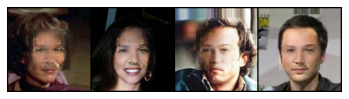

In [ ]:
training(train_loader,test_loader)